# Multinomial Logistic Regression for Ancestry Classification

Developed a **ridge-penalized multinomial logistic regression model** to classify **individual ancestry** into five continental groups (African, European, East Asian, Oceanian, Native American) using **top principal components of genetic data** as features.  
The project focused on implementing **multiclass logistic regression with L2 regularization from scratch**, performing **hyperparameter tuning via five-fold cross-validation**, and generating **class probability predictions** for new individuals, including those with mixed ancestry.

Key aspects of the project included:  
- **Vectorized batch gradient descent** for efficient optimization of the multinomial logistic regression cost function.  
- **L2 regularization (ridge)** to prevent overfitting in a high-dimensional feature space.  
- **Feature standardization and data preprocessing** to ensure stable model training.  
- **Visualization of coefficient paths** across a log-scaled grid of λ values to study the effect of regularization on model complexity.  
- **Five-fold cross-validation** to select the λ that minimized categorical cross-entropy loss.  
- **Prediction of class probabilities** for 111 test individuals, including:  
  - Identification of most probable ancestry for each individual.  
  - Analysis of probability distributions for mixed individuals to reflect historical patterns of population mixing.  

This project demonstrates practical expertise in **multiclass classification, penalized regression, probabilistic modeling, and cross-validation**, as well as the ability to interpret model outputs in a **population genetics context**.

**Keywords:**  
**multinomial logistic regression**, **ridge regularization (L2)**, **batch gradient descent**, **multiclass classification**, **cross-validation**, **categorical cross-entropy**, **probability-based prediction**, **feature standardization**, **population genetics modeling**


# Data Prep

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# set a random seed for reproducibility
np.random.seed(17)

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# connect to data
train_data = '/content/gdrive/My Drive/TrainingData_N183_p10.csv'
print(os.path.exists(train_data))

test_data = '/content/gdrive/My Drive/TestData_N111_p10.csv'
print(os.path.exists(test_data))

True
True


In [ ]:
# read train CSV
train_df = pd.read_csv(train_data)
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African
...,...,...,...,...,...,...,...,...,...,...,...
178,4.562678,1.595991,-6.255160,-3.083079,0.155693,-2.509439,-1.186470,0.641546,2.893239,0.885596,NativeAmerican
179,4.559052,1.581629,-5.121037,-4.312312,0.021703,-0.787173,-1.838054,-0.118590,1.200644,0.885596,NativeAmerican
180,3.101335,1.477101,-5.759153,-2.083745,-0.750615,1.061579,-1.341655,-0.215556,-0.133415,0.885596,NativeAmerican
181,3.235086,-0.974829,-4.049595,0.020907,-0.489322,0.627622,0.087942,0.737715,3.262126,0.885596,NativeAmerican


In [ ]:
# read test CSV
test_df = pd.read_csv(test_data)
test_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,2.517683,5.464283,9.067873,-4.965928,-0.741937,0.039785,0.573279,-0.216918,2.454823,-0.671274,Unknown
1,6.077012,1.032867,-5.795883,-3.490064,-0.600204,-0.120803,1.243767,1.821390,-1.173053,2.442467,Unknown
2,1.016945,-2.913299,0.907702,1.233580,-1.983452,1.605964,2.674998,-0.732921,-2.157438,-0.671274,Unknown
3,-10.860926,2.545077,0.023950,-1.474450,0.372286,-2.609954,-2.794092,1.264747,-3.974644,-0.671274,Unknown
4,4.790262,3.621650,-1.442221,5.459907,-0.864235,-2.591185,-0.062762,0.515344,0.228729,-0.671274,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
106,-11.030349,1.712786,-1.392893,-0.163989,3.623641,-0.263645,-3.337796,2.279226,-2.632659,-0.671274,AfricanAmerican
107,-7.994173,0.045333,-0.738547,0.189793,-2.545140,-0.332066,0.026289,-1.840944,-0.456438,-0.671274,AfricanAmerican
108,-8.874531,2.074620,-2.060999,-0.898143,-1.372896,-3.175091,2.325163,-1.256258,-0.133253,-0.671274,AfricanAmerican
109,-7.017063,-0.199721,-1.469538,-1.997714,1.892038,-1.880466,-3.278863,-0.336890,0.042410,-0.671274,AfricanAmerican


In [ ]:
# extract features and labels
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
#y_test = test_df.iloc[:, -1].values

In [ ]:
# encode the y_train labels (switch strings to integers)

print(f'y_train before encoding: \n{y_train}')

# get unique labels
unique_labels = np.unique(y_train)

# map dictionary of ancestry type to integer
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# encode all y values
y_train = np.array([label_map[label] for label in y_train])

print(f'\n\ny_train after encoding: \n{y_train}')
print(f'\nEncoding Map: \n{label_map}')

y_train before encoding: 
['African' 'African' 'African' 'African' 'African' 'African' 'African'
 'African' 'African' 'African' 'African' 'African' 'African' 'African'
 'African' 'African' 'African' 'African' 'African' 'African' 'African'
 'African' 'African' 'African' 'African' 'European' 'European' 'European'
 'European' 'European' 'European' 'European' 'European' 'European'
 'European' 'European' 'European' 'European' 'European' 'European'
 'European' 'European' 'European' 'European' 'European' 'European'
 'European' 'European' 'European' 'European' 'European' 'European'
 'European' 'European' 'European' 'European' 'European' 'European'
 'European' 'European' 'European' 'EastAsian' 'EastAsian' 'EastAsian'
 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian'
 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian'
 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian'
 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'EastAsian' 'E

In [ ]:
# standardize features
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std

# standardize test features using training mean and std
X_test = (X_test - X_mean) / X_std

In [ ]:
# check the standardizing
means = X_train.mean(axis=0) # should be 0s
variances = X_train.var(axis=0) # should be 1s

print("Train Means:\n", np.round(means,2))
print("\nTrain Variances:\n", variances)


means = X_test.mean(axis=0)
variances = X_test.var(axis=0)

print("\n\nTest Means:\n", np.round(means,2))
print("\nTest Variances:\n", np.round(variances,2))

Train Means:
 [ 0.  0.  0. -0. -0.  0. -0.  0. -0.  0.]

Train Variances:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Test Means:
 [-0.78 -0.56 -0.38 -0.21 -0.36 -0.13 -0.03 -0.06 -0.26  0.13]

Test Variances:
 [1.35 0.26 0.2  0.25 0.61 1.26 1.52 1.76 0.98 1.14]


In [ ]:
# get observations and features
N = X_train.shape[0]
p = X_train.shape[1]

# create ones column
ones_column = np.ones((N, 1))
ones_column_test = np.ones((X_test.shape[0], 1))

# create the design matrix (N x (p + 1))
# add ones column to left side of original matrix
X_train = np.hstack((ones_column, X_train))

# create matrix for test
X_test = np.hstack((ones_column_test, X_test))

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (183, 11)
Test shape: (111, 11)


In [ ]:
# encode y as an indicator matrix Y (N x K)
K = len(np.unique(y_train))
Y = np.zeros((N, K))
for i, clss in enumerate(np.unique(y_train)):
    Y[:, i] = (y_train == clss).astype(int)

## Algorithm 1 Implementation

In [ ]:
# exponential function for unnormalized probabilities
def compute_U(X, B):
    return np.exp(np.dot(X, B))

# compute normalized class probability matrix P
def compute_P(U):
    return U / np.sum(U, axis=1, keepdims=True)

# generate intercept matrix Z
def compute_Z(B):
    Z = np.zeros_like(B)
    Z[0, :] = B[0, :]  # copy intercept row
    return Z

In [ ]:
# define a ridge regression function

def ridgeRegression(X, Y, alpha, lambd, iterations):

    # initialize parameters
    p, K = X.shape[1], Y.shape[1]
    beta = np.zeros((p, K))  # initialize beta matrix to zeroes, shape ((p+1), K)
    beta_history = np.zeros((iterations, p, K))  # track beta values

    # batch gradient descent
    for i in range(iterations):

        # compute unnormalized class probabilitity matrix
          # exponent of each element of XB matrix
        U = compute_U(X, beta)  # shape (N, K)

        # normalized class probabilitity matrix
        P = compute_P(U)  # shape (N, K)

        # exclude intercept term
        Z = compute_Z(beta) # shape ((p+1), K)

        # update parameter vector beta according to mathematical formula
        beta = beta + alpha * (np.dot(X.T, (Y-P)) - 2 * lambd * (beta - Z))

    return beta

## Deliverable 1 - Ridge Regression/Gradient Descent Specific

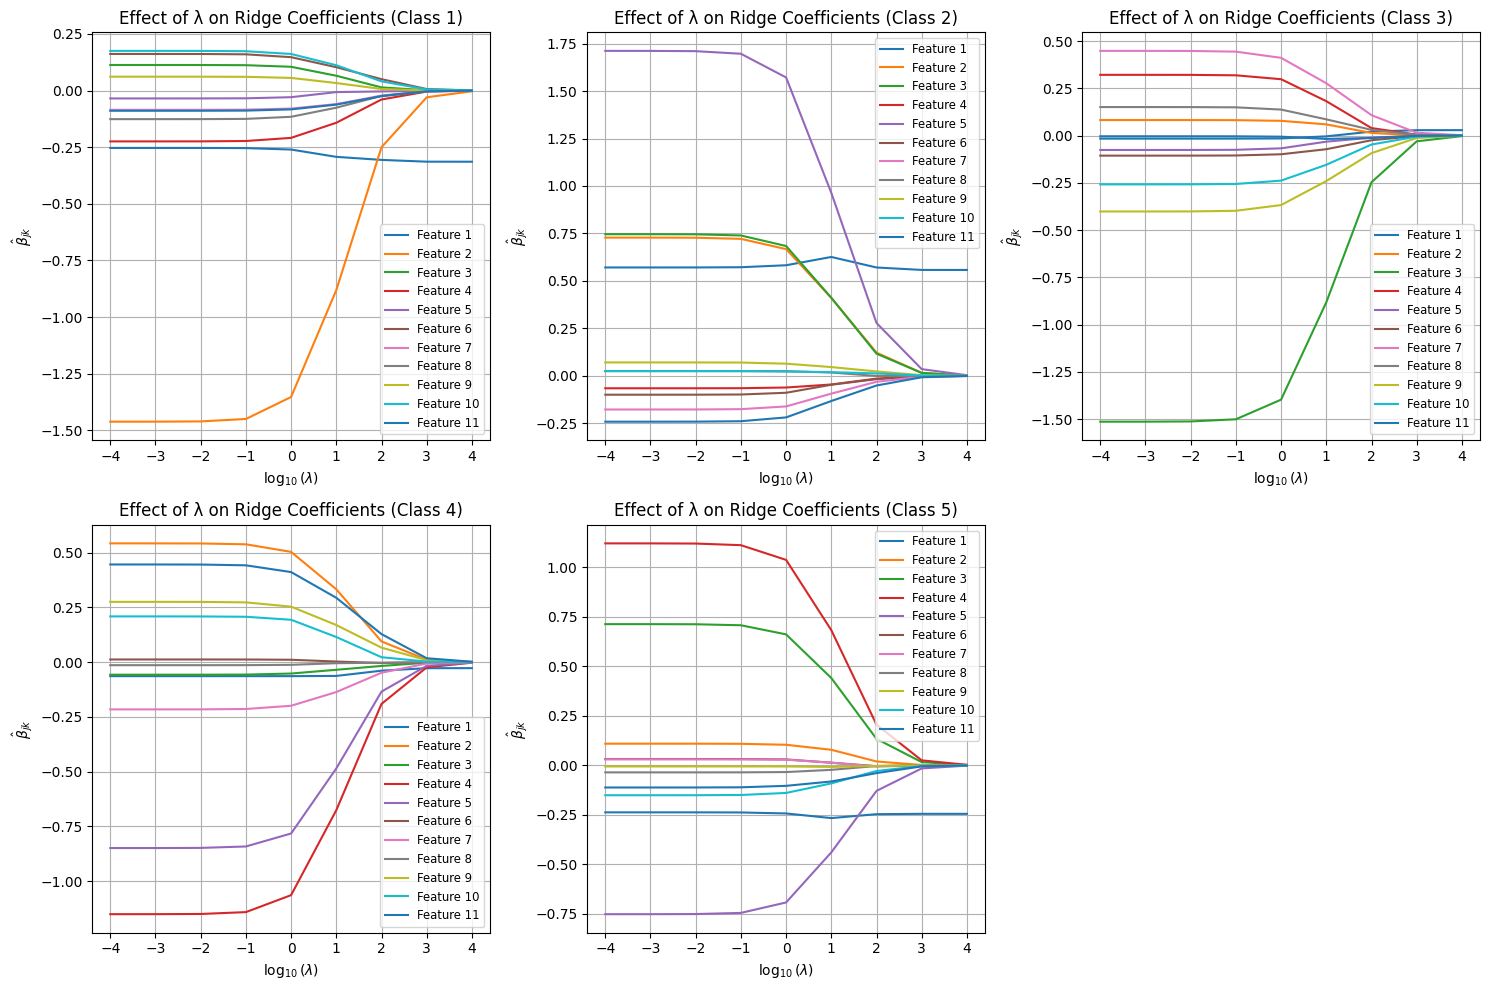

In [ ]:
# plot effect of lambda on ridge coefficients

# define a range of lambda values (log-spaced)
lambdas = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]

alpha = 0.00001 # learning rate
iterations = 10000

# initialize array to store coefficients
coefficients = np.zeros((len(lambdas), p + 1, K)) # shape: (num_lambdas, p+1, K)

# call ridge regression for each lambda
for idx, lambd in enumerate(lambdas):
    beta = ridgeRegression(X_train, Y, alpha=alpha, lambd=lambd, iterations=iterations)
    coefficients[idx, :, :] = beta # store final beta values

# plotting
plt.figure(figsize=(15, 10))
for k in range(K): # loop over classes
    plt.subplot(2, 3, k + 1)

    for j in range(p+1): # loop over features (including bias term)
        plt.plot(np.log10(lambdas), coefficients[:, j, k], label=f'Feature {j+1}')
    plt.title(f'Effect of λ on Ridge Coefficients (Class {k+1})')
    plt.xlabel(r'$\log_{10}(\lambda)$')
    plt.ylabel(r'$\hat{\beta}_{jk}$')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)

plt.tight_layout()
plt.show()


## Deliverable 2

In [ ]:
# define k-fold (5) cross validation function

def cross_validation(X, Y, alpha, lambd, iterations, k_folds=5):

    N = X.shape[0] # no. samples
    shuffled_indices = np.random.permutation(N) # shuffle data indices
    folds = np.array_split(shuffled_indices, k_folds) # split k folds

    errors = [] # store validation errors

    for i in range(k_folds):
        # get indices
        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k_folds) if j != i])

        # create training and validation sets
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_test, Y_test = X[test_idx], Y[test_idx]

        # standardize data (with training stats)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train_std[X_train_std == 0] = 1e-8 # avoid dividing by 0
        X_train = (X_train - X_train_mean) / X_train_std
        X_test = (X_test - X_train_mean) / X_train_std

        # call ridge regression on train
        beta = ridgeRegression(X_train, Y_train, alpha, lambd, iterations)

        # predict on validation set
        U = compute_U(X_test, beta) # compute unnormalized probabilities
        P = compute_P(U) # normalize probabilities

        # compute categorical cross-entropy
        cross_entropy = -np.sum(Y_test * np.log(P + 1e-8)) / len(Y_test)  # use natural log and add epsilon
        errors.append(cross_entropy)

    # return average error across folds
    return np.mean(errors)

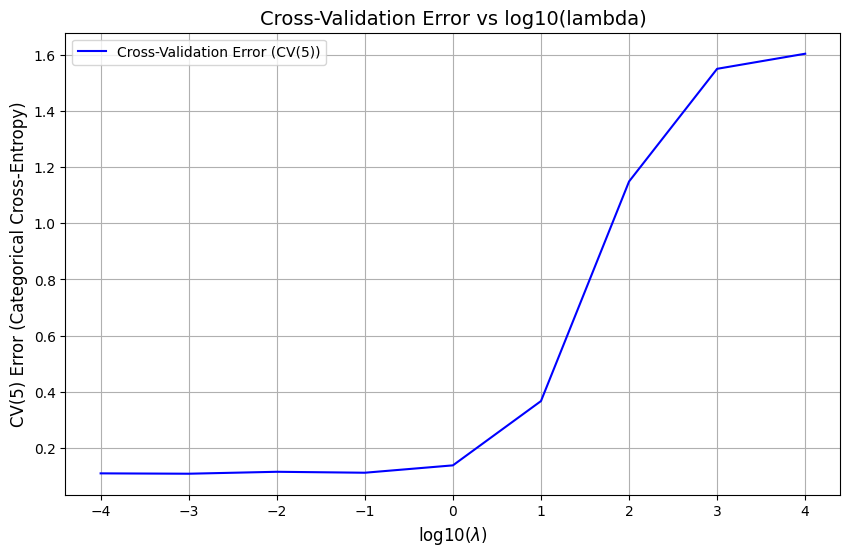

In [ ]:
# CV(5) error plots

# call cross validation function
cv_errors = []
for lambd in lambdas:
    cv_error = cross_validation(X_train, Y, alpha=alpha, lambd=lambd, iterations=iterations, k_folds=5)
    cv_errors.append(cv_error)

# plot cross validation error vs log10(lambda)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas), cv_errors, label='Cross-Validation Error (CV(5))', color='b')
plt.xlabel(r'log10($\lambda$)', fontsize=12)
plt.ylabel('CV(5) Error (Categorical Cross-Entropy)', fontsize=12)
plt.title('Cross-Validation Error vs log10(lambda)', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Deliverable 3

In [ ]:
# find optimal lambda
optimal_lambda = lambdas[np.argmin(cv_errors)]
print(f"Optimal lambda: {optimal_lambda}")

Optimal lambda: 0.001


## Deliverable 4

In [ ]:
# retrain on optimal lambda
beta_hat = ridgeRegression(X_train, Y, alpha=alpha, lambd=optimal_lambda, iterations=iterations)
print(beta_hat)

[[-0.25321784  0.57090925 -0.01645849 -0.06393468 -0.23729825]
 [-1.46156255  0.72815092  0.08174948  0.54253194  0.10913022]
 [ 0.11294213  0.74612927 -1.51403925 -0.05732456  0.71229241]
 [-0.22430501 -0.06532083  0.32105307 -1.15122957  1.11980233]
 [-0.03465748  1.7114599  -0.0765302  -0.84917466 -0.75109756]
 [ 0.16167444 -0.0992145  -0.10646971  0.01223104  0.03177874]
 [-0.08487195 -0.17711141  0.44783019 -0.21582721  0.02998038]
 [-0.12607896  0.02507369  0.15054327 -0.01390269 -0.03563531]
 [ 0.06135499  0.07082754 -0.40195915  0.27541764 -0.00564101]
 [ 0.17529619  0.02524872 -0.25851633  0.20893015 -0.15095874]
 [-0.08905669 -0.24124521 -0.00398344  0.4461804  -0.11189505]]


In [ ]:
# predict probabilities on the test set

# compute the exponentials
exps = np.exp(np.dot(X_test, beta_hat))

# normalize to get probabilities
probs = exps / np.sum(exps, axis=1, keepdims=True)

In [ ]:
# predict class with highest probability
y_pred = np.argmax(probs, axis=1)

# print the predicted labels
print(f"\nTotal predictions: {y_pred.size}")
print("Predicted Labels:", y_pred)
print(f"\nUnique classes and counts: {np.unique(y_pred, return_counts=True)}")


Total predictions: 111
Predicted Labels: [4 3 2 0 1 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 2 2 2 3 2 2 2 3 3 2 2 2 2 3 2 2 3
 2 3 3 3 3 3 2 3 2 2 3 3 2 2 2 2 3 2 3 3 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0]

Unique classes and counts: (array([0, 1, 2, 3, 4]), array([50,  1, 29, 30,  1]))


In [ ]:
# dictionary for results
results_map = {0: 'African', 1: 'EastAsian', 2: 'European', 3: 'NativeAmerican', 4: 'Oceanian'}
results = {f"{results_map[i]}": np.round(probs[:, i], 2) for i in range(probs.shape[1])}
results["Most Probable Label"] = y_pred

# convert to dataframe
df_results = pd.DataFrame(results)
df_results.index = [f"Individual_{i+1}" for i in range(probs.shape[0])]
df_results

,African,EastAsian,European,NativeAmerican,Oceanian,Most_Probable_Label
Individual_1,0.01,0.00,0.01,0.00,0.98,4
Individual_2,0.00,0.00,0.01,0.98,0.00,3
Individual_3,0.01,0.04,0.93,0.01,0.01,2
Individual_4,0.93,0.01,0.01,0.01,0.05,0
Individual_5,0.00,0.99,0.00,0.00,0.00,1
...,...,...,...,...,...,...
Individual_107,0.97,0.00,0.01,0.01,0.01,0
Individual_108,0.70,0.03,0.23,0.02,0.03,0
Individual_109,0.89,0.02,0.03,0.03,0.02,0
Individual_110,0.87,0.01,0.04,0.05,0.03,0


## Deliverable 5

The class probabilities for Mexican and African American samples reflect their historically mixed ancestries, while the "Unknown" samples show distinct, unmixed ancestries.

Mexican samples show high probabilities for NativeAmerican (about 70%) and European (about 20%), consistent with the historical mixing of Indigenous people and European colonizers, including Spaniards. 🌎

African American samples show high probabilities for African (about 85%), with smaller probabilities from European (about 10%) and NativeAmerican (about 5%). This reflects their ancestry from enslaved Africans and historical genetic mixing during and after slavery. 🌍

In contrast, "Unknown" samples, belonging to one of the five ancestries, show very high probabilities (about 93%-99%), reflecting the lack of mixture. This could also be due to the fact that the model was trained on these samples and thus should be able to recognize them well.

The probabilities found on the test set align well with knowledge of population history. Colonization in Mexico led to significant mixing between Native Americans and Europeans, while the transatlantic slave trade and other historical interactions explain the mixture in African Americans. The clear, high probabilities for the "Unknown" samples validates the model's performance. Overall, these class probabilities reflect recent history and genetic mixing of distinct populations.

## Deliverable 7 - Extra Credit

In [ ]:
# using Sci-kit Learn, train multinomial logistic regression model
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',  # optimization
    max_iter=10000,  # same iterations as above
    C=1 / optimal_lambda  # inverse of regularization strength
)
model.fit(X_train, y_train)

# predict test probabilities
sk_probs = model.predict_proba(X_test)

# dictionary for results
sk_results = {f"{results_map[i]}": np.round(sk_probs[:, i], 2) for i in range(sk_probs.shape[1])}

# predict most likely class
sk_results["Most Probable Label"] = model.predict(X_test)

# convert to dataframe
sk_results = pd.DataFrame(sk_results)
sk_results.index = [f"Individual_{i+1}" for i in range(probs.shape[0])]
sk_results



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,African,EastAsian,European,NativeAmerican,Oceanian,Most Probable Label
Individual_1,0.00,0.00,0.00,0.0,1.0,4
Individual_2,0.00,0.00,0.00,1.0,0.0,3
Individual_3,0.00,0.00,1.00,0.0,0.0,2
Individual_4,1.00,0.00,0.00,0.0,0.0,0
Individual_5,0.00,1.00,0.00,0.0,0.0,1
...,...,...,...,...,...,...
Individual_107,1.00,0.00,0.00,0.0,0.0,0
Individual_108,0.98,0.00,0.02,0.0,0.0,0
Individual_109,1.00,0.00,0.00,0.0,0.0,0
Individual_110,1.00,0.00,0.00,0.0,0.0,0
